Yue write the code at 2023/08/24

The final test of the compliance control

Just based on the compliance control mode, change the origin point of the virtual spring to make the leg move in a desired trajectory

In [1]:
import odrive
from odrive.enums import *
import time
import math
from math import sin,cos,pi
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from IPython.display import clear_output
import numpy as np
import serial
import pickle
from controller import COMPLIANCE_CONTROLLER,POSITION_CONTROLLER

def check(my_drive):
    if my_drive.axis1.error == 0:
        print('Everything is fine')
    else:
        print('Error!')

def lowpass_filter(data,cutoff,fs,order):
    b,a=butter(order,2*cutoff/fs,btype='low',analog=False)
    y=filtfilt(b,a,data)
    return y 


In [2]:
# Find a connected ODrive (this will block until you connect one)
print("finding an odrive...")
my_drive = odrive.find_any()
print("Found! and the bus voltage is " + str(my_drive.vbus_voltage) + "V")
print(my_drive.axis0.motor.current_control.i_gain,my_drive.axis1.motor.current_control.i_gain)
my_drive.axis1.motor.current_control.i_gain = 4
my_drive.axis0.motor.current_control.i_gain = 4
print(my_drive.axis0.motor.current_control.i_gain,my_drive.axis1.motor.current_control.i_gain)


my_drive.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
my_drive.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL


check(my_drive)
print('*'*50)


finding an odrive...
Found! and the bus voltage is 27.813940048217773V
79.55815887451172 82.6633529663086
4.0 4.0
Everything is fine
**************************************************


In [3]:
# my_drive.axis1.motor.config.torque_constant = 1
print(my_drive.axis0.motor.config.torque_constant,my_drive.axis1.motor.config.torque_constant)
POS_GAIN=100
my_drive.axis0.controller.config.pos_gain = POS_GAIN
my_drive.axis1.controller.config.pos_gain = POS_GAIN
print('vel_gain and pos_gain of AXIS0 is',my_drive.axis0.controller.config.vel_gain,my_drive.axis0.controller.config.pos_gain)
print('vel_gain and pos_gain of AXIS1 is',my_drive.axis1.controller.config.vel_gain,my_drive.axis1.controller.config.pos_gain)
# my_drive.save_configuration()

1.0 1.0
vel_gain and pos_gain of AXIS0 is 8.0 100.0
vel_gain and pos_gain of AXIS1 is 8.0 100.0


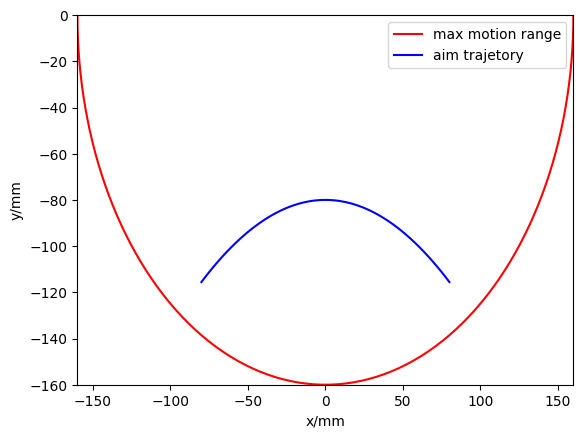

In [4]:
def traje_function(x):
    return (x)**2/180+80
x1=-80
x2=80


x_seq=np.linspace(x1,x2,100)
y_seq=traje_function(x_seq)
theta=np.linspace(-math.pi,0,100)
plt.plot(160*np.cos(theta),160*np.sin(theta),'r',label='max motion range')
plt.plot(x_seq,-y_seq,'b',label='aim trajetory')
plt.xlim(-160,160)
plt.ylim(-160,0)
plt.xlabel('x/mm')
plt.ylabel('y/mm')
plt.legend()
plt.show()

## position control walking

In [ ]:
controller0=POSITION_CONTROLLER()
all_time,all_pos,all_input=controller0.follow_traj(my_drive,10,traje_function,x1,x2)

## compliance control walking

In [ ]:
controller1=COMPLIANCE_CONTROLLER([0.1,0.05],[5e-3,5e-3])
all_time,all_pos,all_input,all_speed=controller1.follow_trajetory(my_drive,10,traje_function,x1,x2)


In [ ]:
# control the end stay at the origin point
# letsgo(motor_pos_at(0,100),2)
print('ready to do the compliance control')
time.sleep(2)

my_drive.axis0.controller.config.control_mode=1
my_drive.axis1.controller.config.control_mode=1

controller=COMPLIANCE_CONTROLLER([0.1,0.1],[3e-3,3e-3])

ref_pos=[0,100]

all_time=[]
all_pos=[]
all_input=[]
all_speed=[]
sample_num=0

t0=time.monotonic()
time.sleep(0.1)
delta=time.monotonic()-t0

while delta<30:
    if delta>10:
        ref_pos=[20,100]
    #controller
    delta,measured_pos,speed,motor_input=controller.control(my_drive,ref_pos,all_pos,all_time,t0)

    #record data
    all_time.append(delta)
    all_pos.append(measured_pos)
    all_input.append(motor_input)
    all_speed.append(speed)

    #display the data
    sample_num+=1
    if sample_num%20==0:
        clear_output()
        print('STIFFNESS:{} \nREF_POSITION:{} \nMEASURED POSITION: {} \nMOTOR INPUT: {} \nCONTROL FREQUENCTY: {}'
              .format(controller.stiffness,np.around(ref_pos,decimals=1),np.around(measured_pos,decimals=1)
                      ,np.around(motor_input,decimals=1),sample_num/delta))
        print('SPEED: {}'.format(np.around(speed,decimals=1)))
        check(my_drive)


print('control_fre={:.1f}Hz'.format(sample_num/10))
test_data=[all_time,all_pos,all_input]
filepath='./test/leg_impedance_control_at_{}with_k={}.pkl'.format(ref_pos,controller.stiffness)
pickle.dump(test_data,open(filepath,'wb'))

In [ ]:
all_pos_array_x=np.array(all_pos)[:,0]
all_pos_array_y=np.array(all_pos)[:,1]

plt.plot(all_time,all_pos_array_x,label='x')
# plt.plot(all_time,all_pos_array_y,label='y')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('end position(mm)')
# plt.xlim(20,45)
plt.show()